In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import college_admissions_experiments as script
import ipdb
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns


In [2]:
# from scipy.stats import ttest_ind
# condition = 'w'
# def test(vect, args, condition, show_first_env=True, plot=False):
    # assert vect.shape == (args.num_applicants,)
    # assert z.shape == (args.num_applicants, )
    # assert condition in ('z', 'w')
    # out1, out2 = [], []
    # for env_idx in range(args.num_envs if not show_first_env else 1):
        # for i in range(0, args.num_applicants, args.applicants_per_round*2):

            # low1, up1 = i, i+args.applicants_per_round
            # low2, up2 = up1, up1+args.applicants_per_round
            # w_t1 = w[env_idx][low1:up1]
            # w_t2 = w[env_idx][low2:up2]
    
            # z_t1 = z[low1:up1]
            # z_t2 = z[low2:up2]

            # vect_t1 = vect[low1:up1]
            # vect_t2 = vect[low2:up2]
            # if condition == 'w':
                # c1 = w_t1 == 1
                # c2 = w_t2 == 1
            # elif condition == 'z':
                # c1 = z_t1 == env_idx+1
                # c2 = z_t2 == env_idx+1
            # data1 = vect_t1[c1]
            # data1mean = data1.mean()
            # data2 = vect_t2[c2]
            # data2mean = data2.mean()

            # if show_first_env and plot:
                # _,ax=plt.subplots(ncols=1 if show_first_env else 2,nrows=2, sharex=True, sharey=True)
                # ax[0].hist(data1, bins='auto')
                # ax[0].axvline(x=data1mean, color='k')
                # ax[0].set_title(f'env {env_idx}, round t')
                # ax[1].hist(data2, bins='auto' )
                # ax[1].axvline(x=data2mean, color='k')
                # ax[1].set_title(f'env {env_idx}, round t+1')
    
            # m1, m2 = data1.mean(), data2.mean()
            # _, pval = ttest_ind(data1, data2, axis=0, equal_var=False, nan_policy='raise')
            # print(f'm1 = {m1:.2f}, m2 = {m2:.2f}, pval = {pval}')
            # out1.append(m1-m2)
            # out2.append(pval)
    # return np.array(out1), np.array(out2)

# meandiffs, pvals = test(b.dot(theta_star[0]), args, condition='z', plot=False)
# fig,ax=plt.subplots(ncols=2)
# n_rounds = args.num_applicants / args.applicants_per_round
# n_rounds = int(n_rounds/2)
# ax[0].hist(meandiffs, bins=n_rounds)
# out, _, _ = ax[1].hist(pvals, bins=n_rounds)
# meandiffs,pvals=test(o[0], args, condition='z', plot=False)
# fig,ax=plt.subplots(ncols=2)

# n_rounds = args.num_applicants / args.applicants_per_round
# n_rounds = int(n_rounds/2)
# ax[0].hist(meandiffs, bins=n_rounds)
# ax[1].hist(pvals,bins=n_rounds)

In [3]:
def _run(seed, num_applicants, applicants_per_round, stream):
    row = {}
    for no_protocol in (True, False):
        cmd = f'--n-cores 1 --num-repeat 1 --num-applicants {num_applicants} --applicants-per-round {applicants_per_round} --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --test-run --generate 1'
        if no_protocol:
            cmd = f'{cmd} --no-protocol'
        if stream:
            cmd = f'{cmd} --stream'
        args = script.get_args(cmd)
        np.random.seed(seed)
        b, x, y, EW, theta, w, z, y_hat, adv_idx, disadv_idx, o, theta_star, pref_vect  = script.generate_data(
            args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
            )

        # considering only the first env.
        env_idx = 0 
        y_env = y[env_idx].flatten() 
        theta_env = theta[env_idx]
        z_env = z==env_idx+1
        
        # final data point or as a function on a range of students/ 
        if args.stream:
            upp_limits = [x for x in range(applicants_per_round*2, num_applicants+1, applicants_per_round)]
        else:
            upp_limits = [num_applicants]
        
        err_list = [None] * len(upp_limits)
        for i, t in tqdm.tqdm(enumerate(upp_limits)):
            # limiting to currently "total students"
            x_round = x[:t]
            y_env_round = y_env[:t]
            z_env_round = z_env[:t]
            theta_env_round = theta_env[:t]

            # picking out only the selected student
            y_env_round_selected = y_env_round[z_env_round]
            # print(x_round.shape, y_env_round.shape, z_env_round.shape, theta_env_round.shape, y_env_round_selected, z_env_round.sum() )

            est = script.our2(x_round, y_env_round_selected, theta_env_round, z_env_round)
            assert theta_star[0].shape == est.shape, f"{theta[0].shape}, {est.shape}"
            err_list[i] = np.linalg.norm(theta_star[0] - est )

        row['no-protocol' if no_protocol else 'protocol'] = err_list
    return row


In [4]:
apr = 1000 
n_rounds = 300
n_runs = 10
stream=True
args_list = [(s, apr*n_rounds, apr, stream) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(_run, args_list )


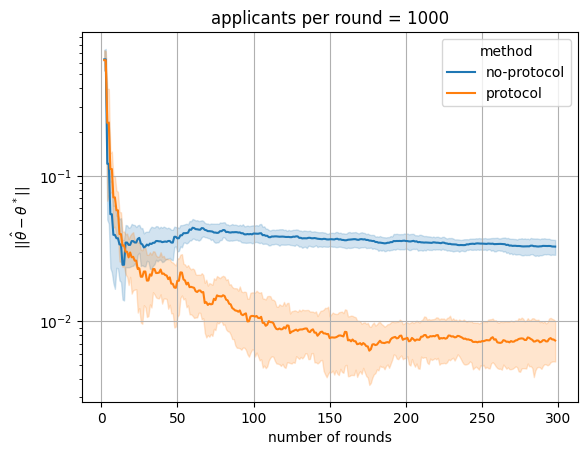

In [6]:
# adding iteration column
for run in runs:
    assert len(run['no-protocol'])==  len(run['protocol'])
    iters = np.arange(len(run['no-protocol']))
    run['iters'] = iters

# create dataframe for this n_rounds.
dfs = []
for run in runs:
    df = pd.DataFrame(run)
    dfs.append(df)
df = pd.concat(dfs)
df

dflong = pd.melt(df, id_vars=('iters',), value_vars=('no-protocol', 'protocol'), var_name='method', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(
    data=dflong, x='iters', y='error', hue='method', ax=ax
)
ax.set_yscale('log')
ax.grid()

ax.set_xlabel('number of rounds')
ax.set_title('applicants per round = 1000')
ax.set_ylabel(r'$||\hat{\theta} - \theta^*||$')

plt.savefig('figures/protocol.pdf')